In [1]:
import os
import pandas as pd
# import tensorflow_datasets as tfds
from google.colab import drive
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Mount your Google Drive to the Colab virtual machine
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# change director
os.chdir('drive/MyDrive/CSCI5502_dataset')
# print
!pwd

/content/drive/MyDrive/CSCI5502_dataset


In [68]:
import numpy as np
import pandas as pd

class ItemBasedCollaborativeFiltering:
    def __init__(self, k_neighbors=5):
        self.k_neighbors = k_neighbors
        self.item_similarity = None
        self.matrix_mean = None

    def preprocess(self, scores_df, courses_df):
        scores_df.dropna(axis=0, inplace=True)
        courses_df.drop('Prerequisite', axis=1, inplace=True)
        courses_df.drop('CourseName', axis=1, inplace=True)
        courses_df.dropna(axis=0, inplace=True)

        df = pd.merge(scores_df, courses_df, on='CourseId', how='inner')

        # Aggregate by score
        agg_scores = df.groupby('CourseId').agg(number_of_scores = ('Score', 'count')).reset_index()
        # Keep the courses with over 100 scores
        agg_scores_GT100 = agg_scores[agg_scores['number_of_scores']>100]

        df_GT100 = pd.merge(df, agg_scores_GT100[['CourseId']], on='CourseId', how='inner')
        return df_GT100

        # pd.DataFrame(cosine_similarity(matrix_norm.fillna(0)), index=matrix_norm.index, columns=matrix_norm.index)


    def create_item_user_matrix(self, preprocessed_df):
        matrix = preprocessed_df.pivot_table(index='CourseName', columns='StudedntId', values='Score')
        # if self.matrix_mean is None:
        #     self.matrix_mean = matrix.mean(axis=1)

        # matrix_norm = matrix.subtract(self.matrix_mean, axis = 0)
        matrix_norm = matrix

        return matrix_norm



    def fit(self, item_user_matrix):
        """
        Fit the collaborative filtering model using the user-item matrix.

        Parameters:
        user_item_matrix (pd.DataFrame): The user-item matrix where rows are users, columns are items, and values are ratings.

        Returns:
        None
        """
        self.item_similarity = self.compute_item_similarity(item_user_matrix)

    def predict(self, item_user_matrix):
        """
        Predict missing values in the user-item matrix.

        Parameters:
        user_item_matrix (pd.DataFrame): The user-item matrix where rows are users, columns are items, and values are ratings.

        Returns:
        pd.DataFrame: The user-item matrix with missing values predicted using collaborative filtering.
        """

        predicted_ratings = item_user_matrix.copy()

        for course, ratings in item_user_matrix.iterrows():
            print("Making prediction for ", course)
            for student_index, rating in ratings.items():
                if not pd.isnull(rating):  # Predict missing values only
                    predicted_ratings.at[course, student_index] = self.predict_score(item_user_matrix, student_index, course)

        return predicted_ratings

    def compute_item_similarity(self, user_item_matrix):
        item_similarity_cosine = pd.DataFrame(cosine_similarity(user_item_matrix.fillna(0)), index=user_item_matrix.index, columns=user_item_matrix.index)
        return item_similarity_cosine

    def predict_score(self, item_user_matrix, student_id, course_name):

        # courses that the target user has taken
        courses_taken = pd.DataFrame(item_user_matrix[student_id].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={student_id:'score'})

        # Similarity score of the course_name picked with all the other courses
        picked_course_similarity_score = self.item_similarity[[course_name]].reset_index().rename(columns={course_name:'similarity_score'})

        # if student has already taken the course, drop it from similarity score
        picked_course_similarity_score = picked_course_similarity_score.drop(picked_course_similarity_score[picked_course_similarity_score['CourseName'] == course_name].index)
        # print(picked_course_similarity_score.head())

        # Rank the similarities between the movies user 1 rated and American Pie.
        picked_student_taken_similarity = pd.merge(left=courses_taken,
                                                    right=picked_course_similarity_score,
                                                    on='CourseName',
                                                    how='inner')\
                                            .sort_values('similarity_score', ascending=False)[:self.k_neighbors]

        if picked_student_taken_similarity['similarity_score'].sum() != 0:
            predicted_rating = round(np.average(picked_student_taken_similarity['score'],
                                        weights=picked_student_taken_similarity['similarity_score']), 6)
        else:
            predicted_rating = 0.0

        return predicted_rating


    def get_top_similar_items(self, item_index, relevant_items):
        """
        Get the top k similar items for a given item.

        Parameters:
        item_index (int): The index of the target item.
        relevant_items (pd.Series): Series containing the ratings of items rated by the target user.

        Returns:
        list: A list of the top k similar items.
        """
        similar_items = self.item_similarity.loc[item_index].dropna()
        top_similar_items = similar_items.reindex(relevant_items.index).sort_values(ascending=False)
        return top_similar_items.index[:self.k_neighbors]

In [69]:
scores_df = pd.read_excel('CourseSelectionTable.xlsx')
courses_df = pd.read_excel('CourseInformationTable.xlsx')

In [70]:
collab_filtering = ItemBasedCollaborativeFiltering(k_neighbors=5)
preprocessed_df = collab_filtering.preprocess(scores_df, courses_df)

In [71]:
train_df, test_df = train_test_split(preprocessed_df, test_size=0.2, random_state=42)

In [72]:
train_matrix = collab_filtering.create_item_user_matrix(train_df)
test_matrix = collab_filtering.create_item_user_matrix(test_df)

In [82]:
train_matrix.shape

(299, 4432)

In [83]:
test_matrix.shape

(299, 4004)

In [73]:
collab_filtering.fit(train_matrix)

In [76]:
student_id = 3
# Pick a movie
course_name = 'A Survey of Mao Tsetung Thoughts and Theory of Socialism with Chinese Characteristics'

score = collab_filtering.predict_score(test_matrix, student_id, course_name)

In [77]:
score

65.768955

In [78]:
preidcted_matrix = collab_filtering.predict(test_matrix)

Making prediction for  A General Survey of World History
Making prediction for  A Guide to Chinese Classic
Making prediction for  A Survey of Mao Tsetung Thoughts and Theory of Socialism with Chinese Characteristics
Making prediction for  A Visual Survey of British and American Culture
Making prediction for  Abstract Algebra
Making prediction for  Academic English Reading
Making prediction for  Academic English Writing
Making prediction for  Advanced Algebra (I)
Making prediction for  Advanced Algebra (II)
Making prediction for  Advanced English Listening and Speaking
Making prediction for  Advanced English Reading
Making prediction for  Advanced Mathematics (B) (1)
Making prediction for  Advanced Mathematics (B) (2)
Making prediction for  Advanced Mathematics (C) (I)
Making prediction for  Advanced Mathematics (D)
Making prediction for  Advanced Oral English
Making prediction for  Aerobics
Making prediction for  American Short Stories Through Films
Making prediction for  An   Introduc

In [84]:
def recommendation(score):
    if score >= 70:
      return 1
    else:
      return 0

In [ ]:
y_true = []
y_pred = []
for course, ratings in test_matrix.iterrows():
    for student_index, rating in ratings.items():
        if not pd.isnull(rating):  # Predict missing values only

            y_true.append(recommendation(test_matrix.at[course, student_index]))
            y_pred.append(recommendation(preidcted_matrix.at[course, student_index]))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

num_correct = np.sum(y_true == y_pred)

accuracy = num_correct / len(y_true)

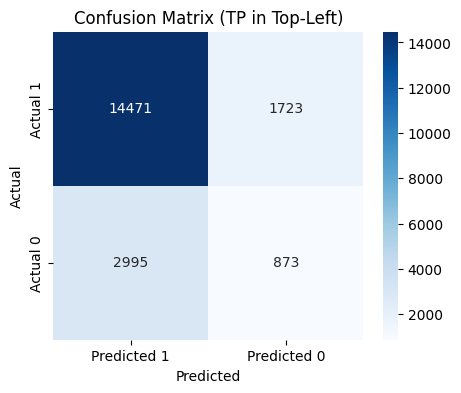

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm_reordered = np.array([[cm[1, 1], cm[1, 0]], [cm[0, 1], cm[0, 0]]])

# Visualize the rearranged confusion matrix using a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_reordered, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['Actual 1', 'Actual 0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (TP in Top-Left)')
plt.show()

In [86]:
accuracy

0.7648290300069783